## 3D Plotting of Interpolated/Simulated volume

In the following notebook we suggest i simple draft version how to display the a volume of interpolated or simulated kriging values in a 3D block model. A simple functio is added to allow a variable threshold, that might be usefull in applications like resource estimation (consider e.g. ore grades).

In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.pardir='../..'
# Importing GemPy
import gempy as gp
# Embedding matplotlib figures in the notebooks
%matplotlib inline
# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set resolution, extent and input data
geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[25,25,25], 
                        path_o = os.pardir+"/data/input_data/jan_models/model2_orientations.csv",
                        path_i = os.pardir+"/data/input_data/jan_models/model2_surface_points.csv") 

Active grids: ['regular']


In [3]:
# define series and assign surfaces
gp.map_series_to_surfaces(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')})

,surface,series,order_surfaces,isBasement,color,id
0,rock1,Strat_Series,1,False,#015482,1
1,rock2,Strat_Series,2,False,#9f0052,2
2,basement,Basement_Series,1,True,#ffbe00,3


In [4]:
# define the interpolator
interp_data = gp.set_interpolation_data(geo_data, compile_theano=True,
                                        theano_optimizer='fast_compile')

Compiling theano function...


INFO (theano.gof.compilelock): Waiting for existing lock by unknown process (I am process '2644')
INFO (theano.gof.compilelock): To manually release the lock, delete C:\Users\Jan\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.7.3-64\lock_dir


Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!


In [5]:
#calcualte the solution
sol = gp.compute_model(geo_data)

../../..\gempy\core\solution.py:253: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


In [6]:
geo_data.surfaces.colors.change_colors()

Click to select new colors.


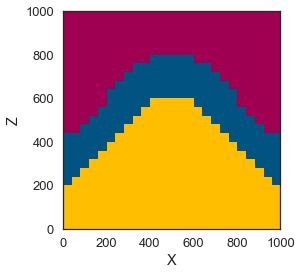

In [7]:
# Plot cross section, which is basically the whole model in this example
gp.plot.plot_section(geo_data, cell_number=0)

In [8]:
geo_data.surfaces

,surface,series,order_surfaces,isBasement,color,id
1,rock2,Strat_Series,1,False,#9f0052,1
0,rock1,Strat_Series,2,False,#015482,2
2,basement,Basement_Series,1,True,#ffbe00,3


In [9]:
import gempy as gp
#importlib.reload(kriging)
from gempy.assets import kriging

In [10]:
cond_data = np.array([[110,0,510,2],[910,0,510,1],[510,0,530,1],[310,0,410,5],
                     [110,500,510,2],[910,500,510,1],[510,500,530,1],[310,500,410,5]])

In [21]:
# Kriging
domain = kriging.domain(model=sol, domain=[2], data=cond_data)
variogram_model = kriging.variogram_model(theoretical_model = 'exponential', range_=100, sill=np.var(cond_data[:,3]))

#solution = kriging.create_kriged_field(domain, variogram_model)
solution = kriging.create_kriged_field(domain, variogram_model)

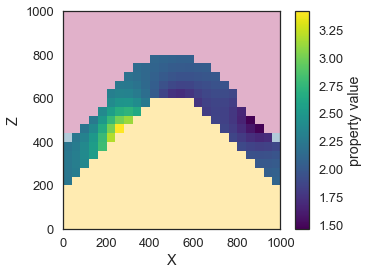

In [22]:
solution.plot_results(geo_data=geo_data, prop='val', contour=False, direction='y', cell_number=0, alpha=0.7,
                          show_data=False, legend=True)

In [23]:
import ipyvolume as ipv
import numpy as np

from matplotlib.cm import ScalarMappable as SM

In [24]:
def plot_3D_blocks(threshold):
    
    x = solution.results_df['X'].values
    y = solution.results_df['Y'].values
    z = solution.results_df['Z'].values
    
    vals = solution.results_df['estimated value'].values
    vals_color = SM(cmap='viridis').to_rgba(vals)
    
    mask = vals > threshold
    
    x = x[mask]
    y = y[mask]
    z = z[mask]
    vals = vals[mask]
    
    block_size = (domain.sol.grid.regular_grid.extent[1]
                  -domain.sol.grid.regular_grid.extent[0])/(domain.sol.grid.regular_grid.resolution[0])/10
    
    ipv.figure()
    ipv.pylab.scatter(x, y, z, color=vals_color[mask], size=block_size, marker="box")

    ipv.xlim(domain.sol.grid.regular_grid.extent[0], domain.sol.grid.regular_grid.extent[1])
    ipv.ylim(domain.sol.grid.regular_grid.extent[2], domain.sol.grid.regular_grid.extent[3])
    ipv.zlim(domain.sol.grid.regular_grid.extent[4], domain.sol.grid.regular_grid.extent[3])
    ipv.show()

In [25]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [27]:
interact(plot_3D_blocks, threshold=(1,2.6,0.1));

interactive(children=(FloatSlider(value=1.8, description='threshold', max=2.6, min=1.0), Output()), _dom_class…